# Google Revenue Prediction

## Kaggle Challenge Description

## What are we predicting?
We are predicting the **natural log** of the sum of all transactions **per user**.

$$ y_{user} = \sum_{i=1}^n transaction_{user_{i}} $$
$$ target_{user} = ln(y_{user} + 1) $$

## Data Cleansing 

Simply change csv_file to either "test_v2.csv" or "train_v2.csv" to determine which csv to use. Using "test_v2.csv" will make it easier to manage for your system.

In [1]:
%%time
import pandas as pd
import sklearn
from sklearn import model_selection, preprocessing, metrics
import json
import os
import matplotlib
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import numpy as np
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import mean_squared_error



/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


ModuleNotFoundError: No module named 'seaborn'

In [2]:
%%time
data = 'data'
def load_csv(data, csv_file, nrows):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    print("Loading csv file")
    df = pd.read_csv(os.path.join(os.getcwd(),data,csv_file),
                    converters={column: json.loads for column in JSON_COLUMNS},
                    dtype={'fullVisitorId': 'str'},
                    nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["%s.%s" % (column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
#      Convert feature type
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].astype('float')
    
    return df

# Load both the training csv and testing csv
train_df = load_csv(data, "train_v2.csv",None)
test_df = load_csv(data, "test_v2.csv", None)

print("Loading done.")


Loading csv file
Loading csv file
Loading done.
CPU times: user 13min 17s, sys: 12min 2s, total: 25min 19s
Wall time: 30min 16s


## Columns and Types
Initially we should dissect the data and learn what columns are found inside the csv file.

In [3]:
train_df.dtypes

channelGrouping                                       object
customDimensions                                      object
date                                                   int64
fullVisitorId                                         object
hits                                                  object
socialEngagementType                                  object
visitId                                                int64
visitNumber                                            int64
visitStartTime                                         int64
device.browser                                        object
device.browserSize                                    object
device.browserVersion                                 object
device.deviceCategory                                 object
device.flashVersion                                   object
device.isMobile                                         bool
device.language                                       object
device.mobileDeviceBrand

## Feature Engineering and Data Exploration

Create 4 additional features from *date* feature: year, month, day, weekday. We will use those to better understand our data.

In [4]:
def add_time_features(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df['weekday'] = df['date'].apply(lambda x: x.weekday())
    return df
add_time_features(test_df)
temp_df = add_time_features(train_df)

## Data Exploration



Group date by date, year, month, day, weekday and aggregate by count/sum.

In [5]:
time_agg = train_df.groupby('date')['totals.transactionRevenue'].agg(['count', 'sum'])
year_agg = train_df.groupby('year')['totals.transactionRevenue'].agg(['sum'])
month_agg = train_df.groupby('month')['totals.transactionRevenue'].agg(['sum'])
day_agg = train_df.groupby('day')['totals.transactionRevenue'].agg(['sum'])
weekday_agg = train_df.groupby('weekday')['totals.transactionRevenue'].agg(['count','sum'])

### Target Variable Exploration

We need to sum up the transaction revenue on the user level. Then graph a scatter plot of the natural log.


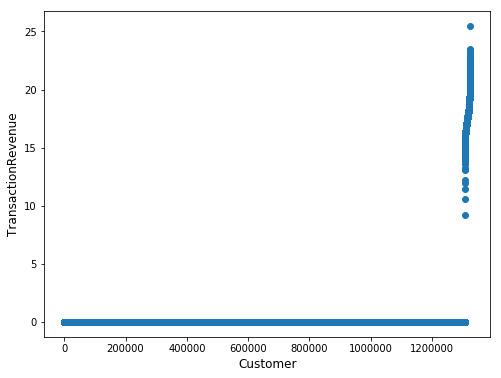

In [6]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('Customer', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

The scatter plot above confirms the 80/20 marketing principle that states 80% of the profits come from 20% of the customers.

From this analysis, this would mean that we have a distinct dataset between customers with TransactionRevenue and customers without TransactionRevenue.


**Sum of transactionRevenue, our target, through the time.**

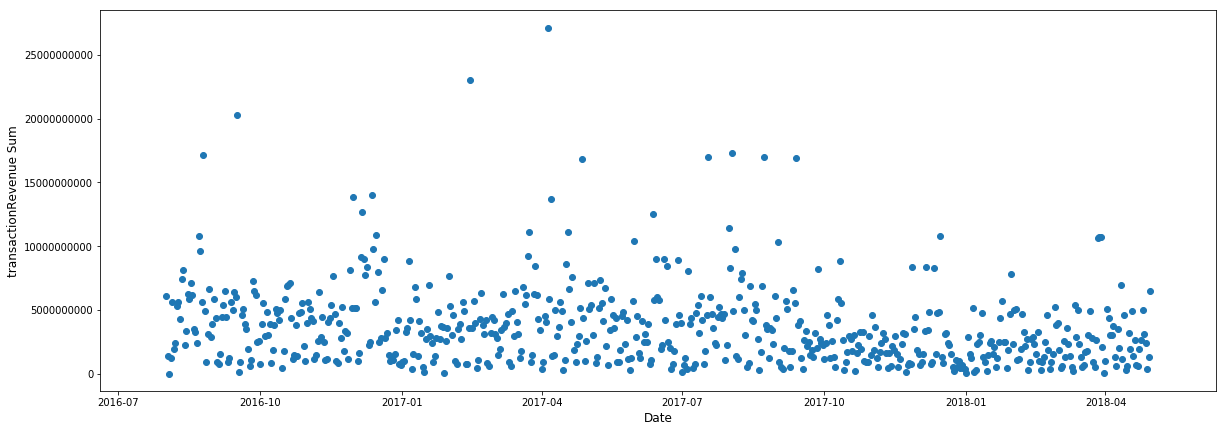

In [7]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('transactionRevenue Sum', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['sum'])
plt.show()

**Count of transactionRevenue our target, through the same time period.**

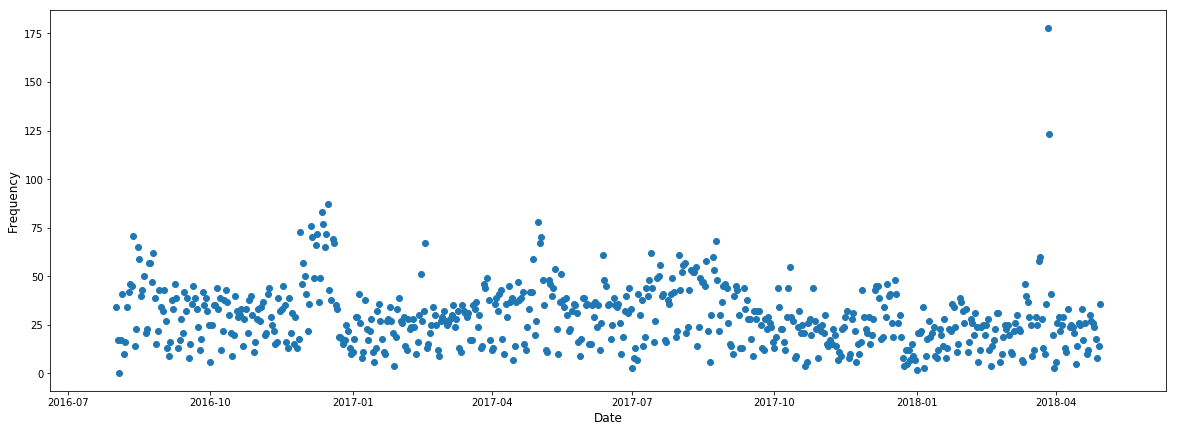

In [8]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.scatter(time_agg.index.values, time_agg['count'])
plt.show()

### Analyze engineered time features

**Sum of transactionRevenue over each year**

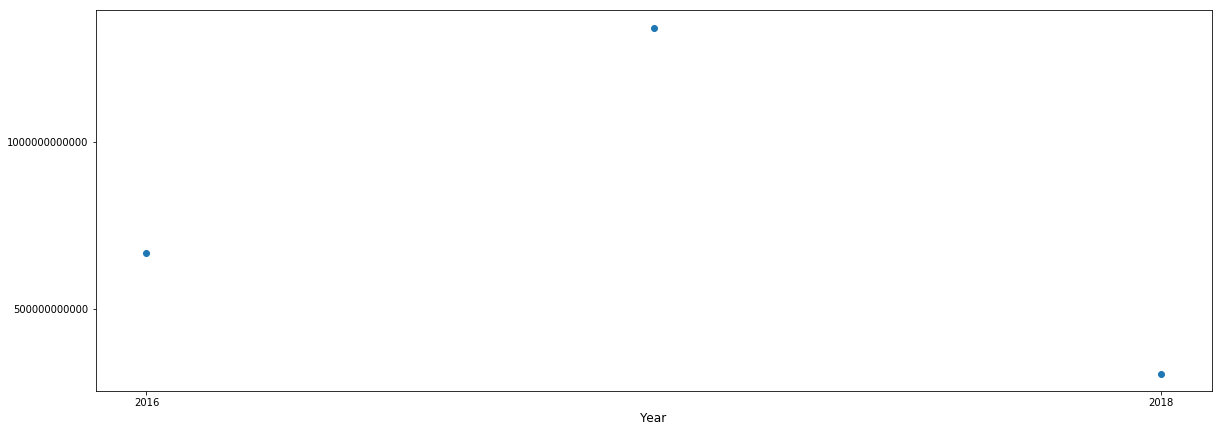

In [9]:
plt.figure(figsize=(20,7))
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Year', fontsize=12)
plt.locator_params(nbins=2)
plt.scatter(year_agg.index.values, year_agg['sum'])
plt.show()

**Insight:** There is a large increase from 2016 to 2017.

**Sum of transactionRevenue over monthly period**

**Insight:** There is a spike in revenue in December, April and August.
December makes sense as it is holiday season. What drives April and August sales?

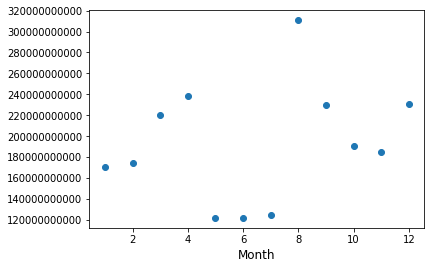

In [10]:
plt.scatter(month_agg.index.values, month_agg['sum'])
plt.locator_params(nbins=12)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Month', fontsize=12)
plt.show()

**Sum of transactionRevenue daily**

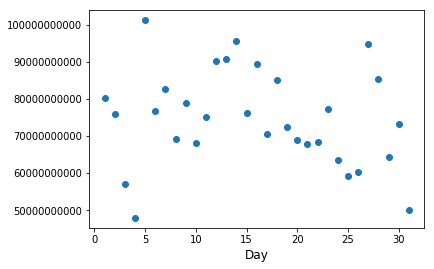

In [11]:
plt.scatter(day_agg.index.values, day_agg['sum'])
plt.locator_params(nbins=10)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Day', fontsize=12)
plt.show()

**Insight:** No insights here, useless feature.

**Sum of transactionRevenue on weekdays**

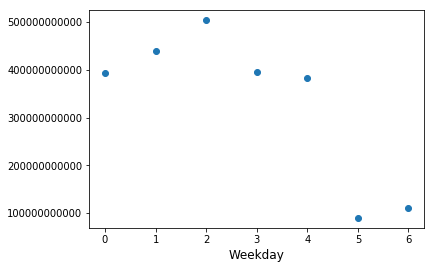

In [12]:
plt.scatter(weekday_agg.index.values, weekday_agg['sum'])
plt.locator_params(nbins=7)
plt.ticklabel_format(axis='y', style='plain')
plt.xlabel('Weekday', fontsize=12)
plt.show()

**Insight:** Weekends bring less revenue than weekdays as it makes sense because Google Office has more visitors during the weekdays - remember it is still a workplace.

## Prepare data for modeling

### Analyzing which Columns are constant

In [13]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

We should also remove the constant columns, as they will bring no bearing to the weights on the model.

In [14]:
cols_to_drop = const_cols
#+ ["trafficSource.campaignCode"]
train_df = train_df.drop(cols_to_drop,axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

Remove columns that primarily contain *null* values. (more than 50%)

**Uncomment when running in production**

In [16]:
null_columns = [c for c in train_df.columns if train_df[c].count()<=len(train_df) * 0.5]
train_df.drop(null_columns, axis=1)
null_columns = [c for c in test_df.columns if test_df[c].count()<=len(test_df) * 0.5]
test_df.drop(null_columns, axis=1)

print("Columns that primarily contain null values: ")
for c in null_columns:
    print(c)

Columns that primarily contain null values: 
totals.bounces
totals.totalTransactionRevenue
totals.transactionRevenue
totals.transactions
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.isTrueDirect


### One-hot Encoding

In [ ]:
categorical_features = ['device.isMobile','year', 'month', 'weekday']
train_df = pd.get_dummies(train_df, columns=categorical_features)
test_df = pd.get_dummies(test_df, columns=categorical_features)

Train and Test datasets must be aligned using an outer joing in order to have the same amount of features. It is an important step for training and inference.

In [ ]:
train_df, test_df = train_df.align(test_df, join='outer', axis=1)

# replace the null values added by join for 0
train_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.replace(to_replace=np.nan, value=0, inplace=True)

# Developing the Model: LGBM
To discover which is the best model to predict the log revenue of customers. We can do a training analysis based on popular models such as LightGBM, ADABOOST and XGBOOST. All these models can be found in scikit-learn.

First, we need to build the training and testing dataset respectively.

In [ ]:
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.metro", "geoNetwork.country",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

train_set,test_set = model_selection.train_test_split(train_df, test_size=0.2)

train_Y = np.log1p(train_set["totals.transactionRevenue"].values)
val_Y = np.log1p(test_set["totals.transactionRevenue"].values)

train_X = train_set[cat_cols+num_cols]
val_X = test_set[cat_cols+num_cols]
test = test_df[cat_cols + num_cols]

## Training Features

In [ ]:
for x in train_X:
    print(x)

## LightGBM

In [ ]:
## TODO: Build LightGBM training function.
def train_with_gbm(train_X,train_Y,val_x,val_y,test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_Y)
    lgval = lgb.Dataset(val_x, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_x, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = train_with_gbm(train_X, train_Y, val_X, val_Y, test)

## Model Evaluation

## Feature Importance

In [ ]:
lgb.plot_importance(model, figsize=(15, 10))
plt.show()

In [ ]:
# Make prediction on validation data.
val_predictions = model.predict(val_X, num_iteration=model.best_iteration)
# Get min and max values of the predictions and labels.
min_val = max(max(val_predictions), max(val_Y))
max_val = min(min(val_predictions), min(val_Y))

# Create dataframe with validation predicitons and labels.
val_df = pd.DataFrame({"Label":val_Y})
val_df["Prediction"] = val_predictions

# Plot data
sns.set(style="darkgrid")
sns.jointplot(y="Label", x="Prediction", data=val_df, kind="reg", color="m", height=10)
plt.plot([min_val, max_val], [min_val, max_val], 'm--')
plt.show()

## Metrics

Mean Squared Error is used as a primary metric. 

In [ ]:
val_predictions[val_predictions<0] = 0
mse = mean_squared_error(val_predictions, val_Y)
rmse = np.sqrt(mse)

print('Model validation metrics')
print('MSE: %.2f' % mse)
print('RMSE: %.2f' % rmse)

## Create a Submission Dataframe

For each visitor id, we predict the **natural log** of the sum of all transactions **per user**.

$$ y_{user} = \sum_{i=1}^n transaction_{user_{i}} $$
$$ target_{user} = ln(y_{user} + 1) $$

In [ ]:
predictions = model.predict(test, num_iteration=model.best_iteration)
visitor_ids = test_df["fullVisitorId"].values

submission = pd.DataFrame({"fullVisitorId":visitor_ids})
predictions[predictions<0] = 0
submission["PredictedLogRevenue"] = predictions
submission = submission.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
submission.columns = ["fullVisitorId", "PredictedLogRevenue"]
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"]
submission.head(10)

## Deep Learning Approach